# GridWorld Capture the Flag Test Environment

In [1]:
from gridworld_ctf import GridworldCtf
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
import random
from matplotlib import pyplot as plt
from collections import deque
import copy


In [2]:
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

False
False


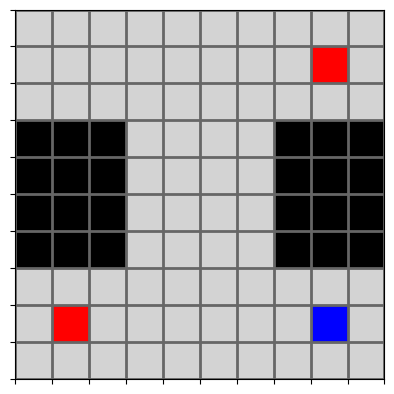

In [3]:
# instantiate environment
env = GridworldCtf(game_mode='static')
env.render()

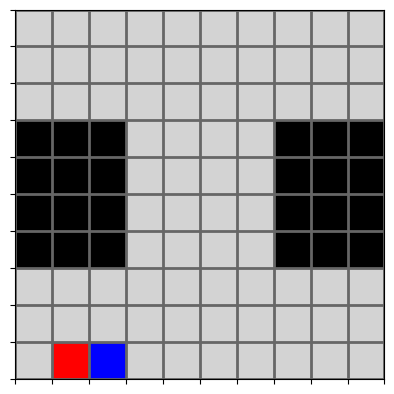

reward: -1, done: False
You win!, total score 76


In [3]:
# Play the gridworld
env.play()

### DQN

In [5]:
# models
l1 = 100
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4)
)

model2 = copy.deepcopy(model) #A
model2.load_state_dict(model.state_dict()) #B

loss_fn = torch.nn.MSELoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [3]:
# cnn model

# Reminder: height and width of next conv layer = W_1 = [(W_0 + 2P - F)/S] + 1
class Net(nn.Module):
    def __init__(self, use_device=None):
        super().__init__()
        # channels / filters / filter size
        self.conv1 = nn.Conv2d(1, 3, 3)
        #self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 8, 3)
        self.fc1 = nn.Linear(8*6*6, 128)
        self.fc2 = nn.Linear(128, 4)
        #self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        if use_device is not None:
            self.to(use_device)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
# train agent
# Mac CPU: 22:47.1s
# Mac GPU: 
env = GridworldCtf(game_mode='static')
device = "cpu"

# create models
model = Net()
print(model)
model2 = copy.deepcopy(model) #A
model2.load_state_dict(model.state_dict()) #B

loss_fn = torch.nn.MSELoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

# train agents
env_dims = (1, 1, 10, 10)
epochs = 2000
losses = []
score_history = []
mem_size = 2000
batch_size = 128
replay = deque(maxlen=mem_size)
n_random_steps = 500
max_moves = 200
h = 0
sync_freq = 500 #A
j = 0

for i in range(epochs):
    env.reset()

    state1_ = env.grid.reshape(*env_dims) + np.random.rand(*env_dims)/100.0
    state1 = torch.from_numpy(state1_).float().to(device)

    status = 1
    mov = 0
    score = 0
    while(status == 1): 
        j+=1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.cpu().numpy()

        # random action selection
        if (random.random() < epsilon) or (i < n_random_steps):
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        
        state2, reward, done = env.step(action_)
        state2_ = state2.reshape(*env_dims) + np.random.rand(*env_dims)/100.0

        score += reward

        state2 = torch.from_numpy(state2_).float().to(device)

        # Append replay buffer
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size and i >= n_random_steps:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]).to(device)
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch]).to(device)
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch]).to(device)
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch]).to(device)
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch]).to(device)
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch) #B
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0: #C
                model2.load_state_dict(model.state_dict())
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
        
    score_history.append(score)

    if i % 100 == 0:
        clear_output(wait=True)
        print(f'episode:{i} \nscore:{score} \naverage score:{np.mean(score_history[-100:])}')

losses = np.array(losses)

#A Set the update frequency for synchronizing the target model parameters to the main DQN
#B Use the target network to get the maiximum Q-value for the next state
#C Copy the main model parameters to the target network

episode:1900 
score:71 
average score:63.52


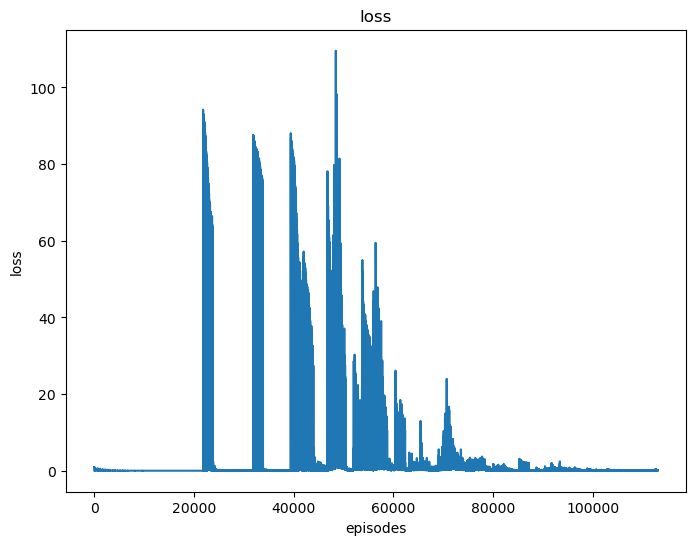

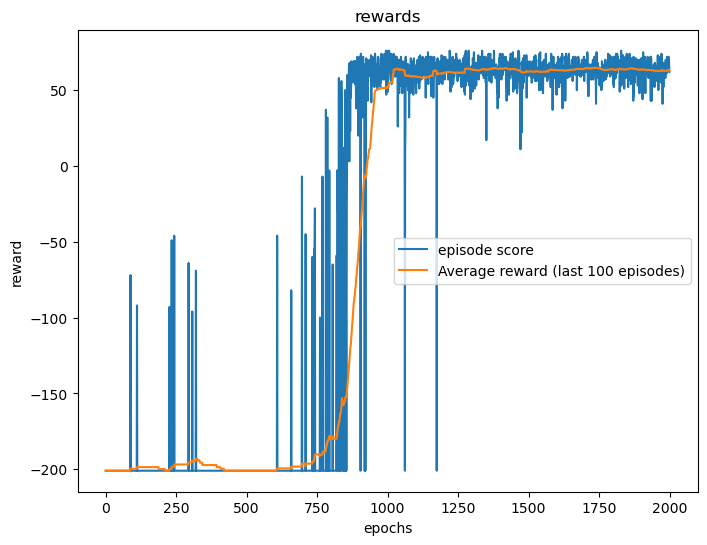

In [6]:
# Plot losses
plt.figure(figsize=(8, 6))
plt.title('loss')
plt.plot(losses)
plt.xlabel("episodes")
plt.ylabel("loss")

# Plot rewards
plt.figure(figsize=(8, 6))
plt.title('rewards')
plt.plot(score_history, label='episode score')
plt.plot([np.mean(score_history[::-1][i:i+100]) for i in range(len(score_history))][::-1], label='Average reward (last 100 episodes)')
plt.xlabel("epochs")
plt.ylabel("reward")
plt.legend()
plt.show()

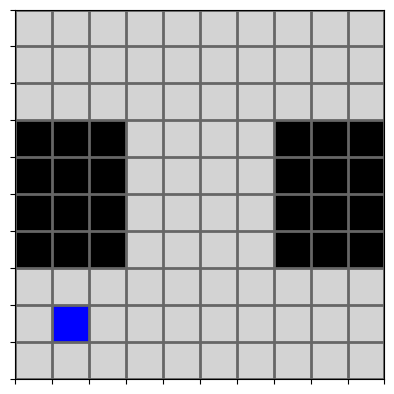

Game won! score: 76


True

In [7]:
def test_model(env, model, env_dims, display=True, max_moves=30):
    i = 0
    env.reset()

    state_ = env.grid.reshape(*env_dims) + np.random.rand(*env_dims)/100.0
    state = torch.from_numpy(state_).float()
    if display:
        #print("Initial State:")
        #print(env.display_grid())
        env.render(sleep_time=0.25)
    status = 1
    score = 0
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B

        state_, reward, done = env.step(action_)

        state = state_.reshape(*env_dims) + np.random.rand(*env_dims)/100.0
        state = torch.from_numpy(state).float()

        score += reward
        if display:
            env.render(sleep_time=0.25)

        if done:
            status = 2
            if display:
                print("Game won! score: %s" % (score,))
        i += 1
        if (i > max_moves):
            if display:
                print(f"Game lost; too many moves. Final score: {score}")
            break
    
    win = True if status == 2 else False
    return win

env_dims = (1, 1, 10, 10)
test_model(env, model, env_dims, display=True)

### Reinforce

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # channels / filters / filter size
        self.conv1 = nn.Conv2d(1, 3, 3)
        #self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 8, 3)
        self.fc1 = nn.Linear(8*6*6, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [14]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = torch.pow(gamma, torch.arange(lenr).float()) * rewards #A
    disc_return /= disc_return.max() #B
    return disc_return

#A Compute exponentially decaying rewards
#B Normalize the rewards to be within the [0,1] interval to improve numerical stability

def loss_fn(preds, r): #A
    return -1 * torch.sum(r * torch.log(preds)) #B

#A The loss function expects an array of action probabilities for the actions that were taken and the discounted rewards.
#B It computes the log of the probabilities, multiplies by the discounted rewards, sums them all and flips the sign.


# create models
model = Net()
print(model)
model2 = copy.deepcopy(model) #A
model2.load_state_dict(model.state_dict()) #B

learning_rate = 0.00005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

Net(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


In [24]:
N_EPISODES = 1000
N_STEPS = 200

gamma = 0.99
env = GridworldCtf(game_mode='static')
env_dims = (1, 1, 10, 10)
losses = []
score_history = []

for i in range(N_EPISODES):
    env.reset()
    curr_state_ = env.grid.reshape(*env_dims) + np.random.rand(*env_dims)/100.0
    curr_state = torch.from_numpy(curr_state_).float()
    done = False
    transitions = deque() #B
    
    for t in range(N_STEPS): #C
        act_prob = model(curr_state)[0] #D
        action = np.random.choice(np.arange(4), p=act_prob.data.numpy()) #E
        prev_state = curr_state.reshape(1, 10, 10)
        curr_state_, reward, done = env.step(action) #F
        curr_state_ = env.grid.reshape(*env_dims) + np.random.rand(*env_dims)/100.0
        curr_state = torch.from_numpy(curr_state_).float()

        transitions.append((prev_state, action, reward)) #G
        if done: #H
            break

    reward_batch = torch.Tensor([r for (s, a, r) in transitions]).flip(dims=(0,)) #J
    score_history.append(sum(reward_batch.numpy()))
    disc_returns = discount_rewards(reward_batch) #K
    state_batch = torch.Tensor([s.numpy() for (s, a, r) in transitions]) #L
    action_batch = torch.Tensor([a for (s, a, r) in transitions]) #M

    pred_batch = model(state_batch) #N
    prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1,1)).squeeze() #O
    
    loss = loss_fn(prob_batch, disc_returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.detach().numpy())

    if i % 50 == 0:
        clear_output(wait=True)
        print(f'episode:{i} \naverage score:{np.mean(score_history[-100:])}')

#A List to keep track of the episode length over training time
#B List of state, action, rewards (but we ignore the reward)
#C While in episode
#D Get the action probabilities
#E Select an action stochastically
#F Take the action in the environment
#G Store this transition
#H If game is lost, break out of the loop
#I Store the episode length
#J Collect all the rewards in the episode in a single tensor
#K Compute the discounted version of the rewards
#L Collect the states in the episode in a single tensor
#M Collect the actions in the episode in a single tensor
#N Re-compute the action probabilities for all the states in the episode
#O Subset the action-probabilities associated with the actions that were actually taken 

episode:950 
average score:-200.0


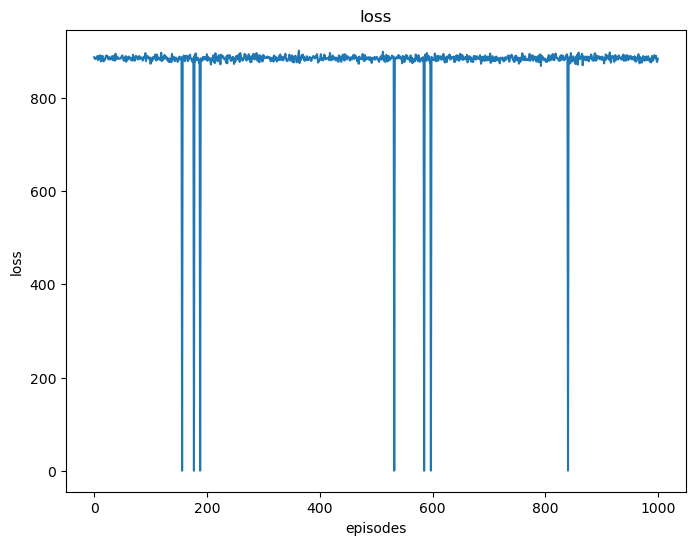

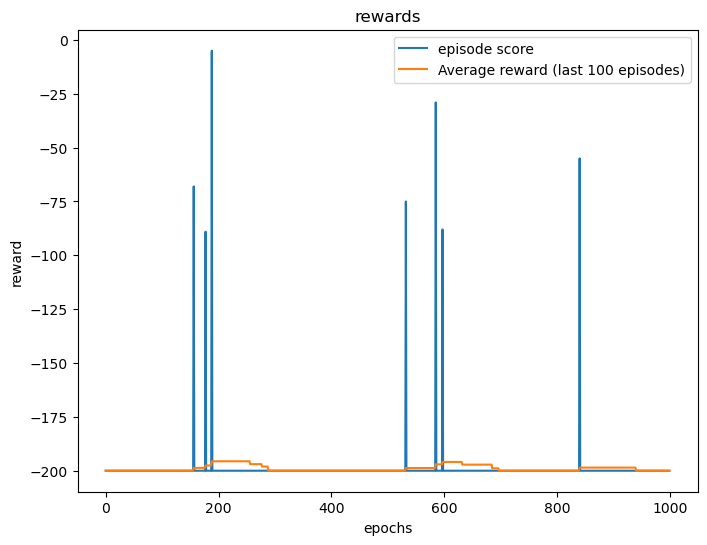

In [26]:
# Plot losses
plt.figure(figsize=(8, 6))
plt.title('loss')
plt.plot(losses)
plt.xlabel("episodes")
plt.ylabel("loss")

# Plot rewards
plt.figure(figsize=(8, 6))
plt.title('rewards')
plt.plot(score_history, label='episode score')
plt.plot([np.mean(score_history[::-1][i:i+100]) for i in range(len(score_history))][::-1], label='Average reward (last 100 episodes)')
plt.xlabel("epochs")
plt.ylabel("reward")
plt.legend()
plt.show()